In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings('ignore')
import logging
logging.getLogger('matplotlib.mathtext').setLevel(logging.WARNING)

import sys, os
sys.path.append(os.path.abspath("metrics"))

import yaml

from models.sbts_uni_markovian import *
from models.sbts_multi_markovian import *
from models.sbts_multi import *
from metrics.fbm_stock_metrics.configs.config import *
from metrics.fbm_stock_metrics.src.evaluations.summary import full_evaluation_latest
from metrics.eval_functions import *
from metrics.get_params import *
from utils.data_generation import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Parameters Estimation: Illustration on Ornstein-Uhlenbeck Data

In [5]:
M = 500
Generate_data = Generate_Data(M)

theta_range = [0.5, 2.5]
mu_range = [0.5, 1.5]
sigma_range = [0.1, 0.5]

N = 252
deltati = 1/252

X_ou = Generate_data.generate_OU(theta_range, mu_range, sigma_range, N)

while X_ou.min() <= 0:  # make sure we keep positive prices
    X_ou = Generate_data.generate_OU(theta_range, mu_range, sigma_range, N)
    
log_returns = np.zeros((M, N+1))
log_returns[:,1:] = np.diff(np.log(X_ou), axis=1)
X_ou = X_ou[:, 1:]

print(X_ou.shape, log_returns.shape)

(500, 252) (500, 253)


In [14]:
log_returns_sbts = simusbts_mark(N, M, K=2, X=log_returns, N_pi=100, h=0.1, deltati=deltati, M_simu=500)
X_ou_sbts = np.exp(log_returns_sbts.cumsum(axis=1))
X_ou_sbts.shape

Start time: 09:06:33
Expected finish time: 09:09:21
Finish time: 09:09:27
Time with numba to generate 500 samples with N_pi=100: 173 seconds.


(500, 252)

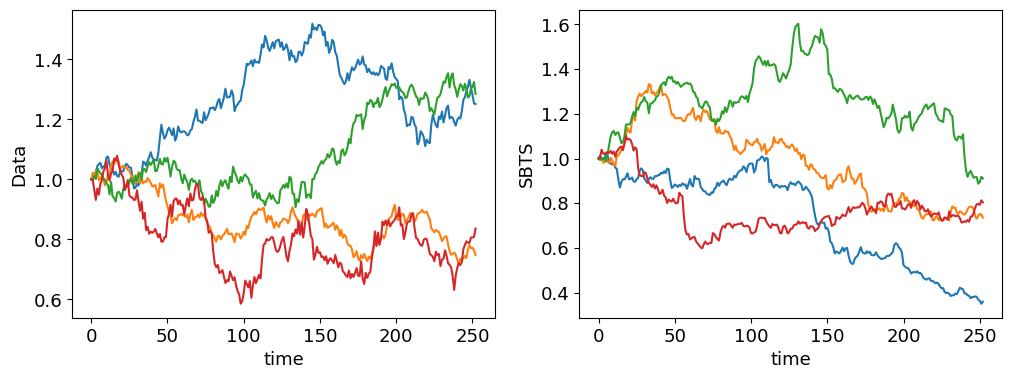

In [38]:
plot_sample(X_ou, X_ou_sbts, 1)

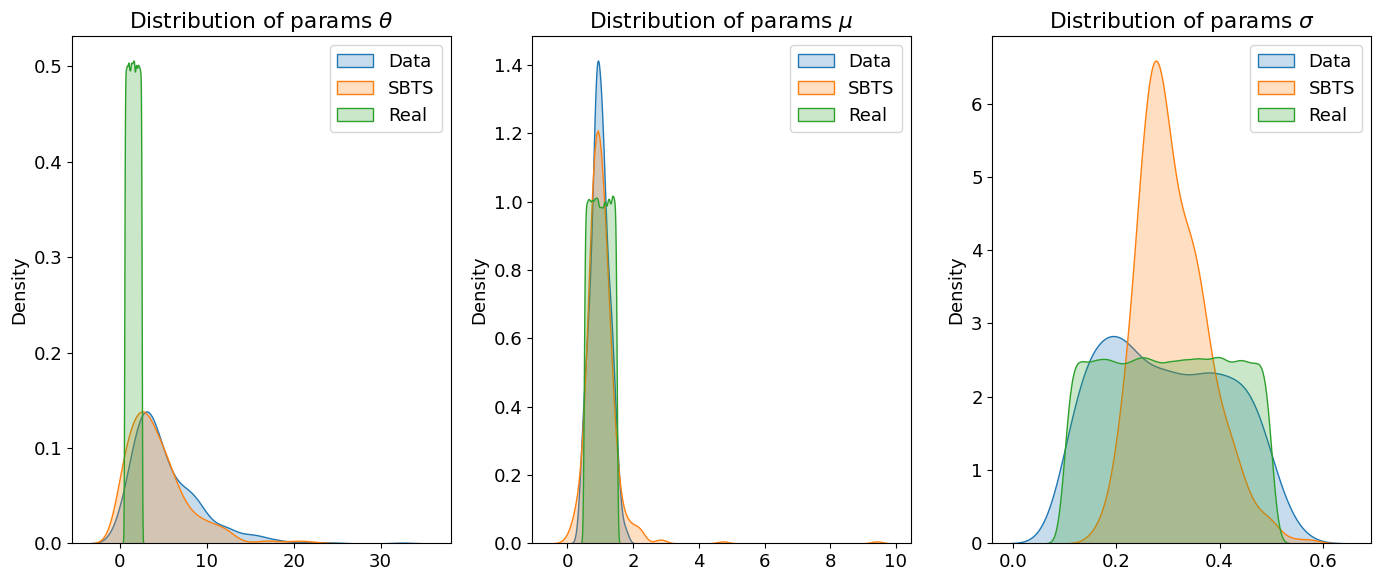

In [39]:
plot_params_distrib_OU(X_ou, X_ou_sbts, dt=deltati)

## Parameters Estimation: Illustration on Heston Data

In [32]:
M = 500
Generate_data = Generate_Data(M)

r_range = [0.02, 0.1]
kappa_range = [0.5, 4.]
theta_range = [0.5, 1.5]
rho_range = [-0.9, 0.9]
xi_range = [0.01, 0.9]
N = 252
deltati = 1/252

X_heston = Generate_data.generate_Heston(r_range, kappa_range, theta_range, rho_range, xi_range, N)
log_returns = np.zeros((M, N+1, 2))
log_returns[:,1:] = np.diff(np.log(X_heston), axis=1)
X_heston = X_heston[:, 1:]

print(X_heston.shape, log_returns.shape)

(500, 252, 2) (500, 253, 2)


In [48]:
log_returns_sbts = simulateSB_multi_mark(N, M, d=2, K=1, X=log_returns, N_pi=100, h=0.2, deltati=deltati, M_simu=500)
X_heston_sbts = np.exp(log_returns_sbts.cumsum(axis=1))

Start time: 08:06:22
Expected finish time: 08:10:55
Finish time: 08:10:52
Time with numba to generate 500 samples with N_pi=100: 269 seconds.


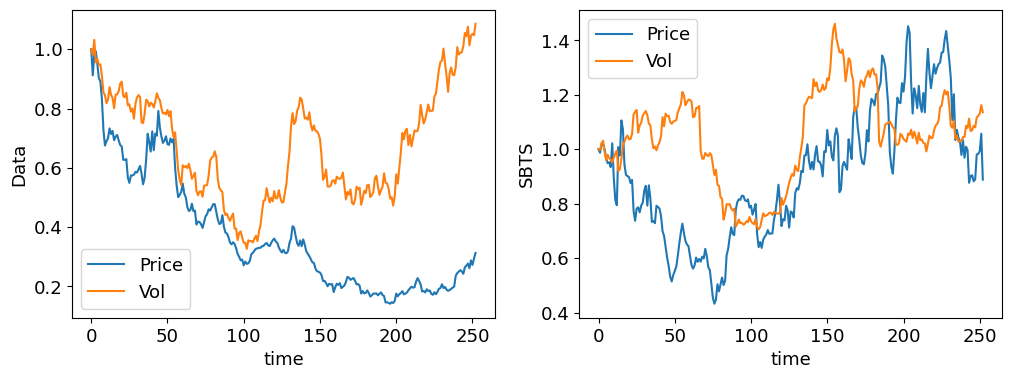

In [70]:
plot_sample_multi(X_heston, X_heston_sbts, ['Price', 'Vol'], 1)

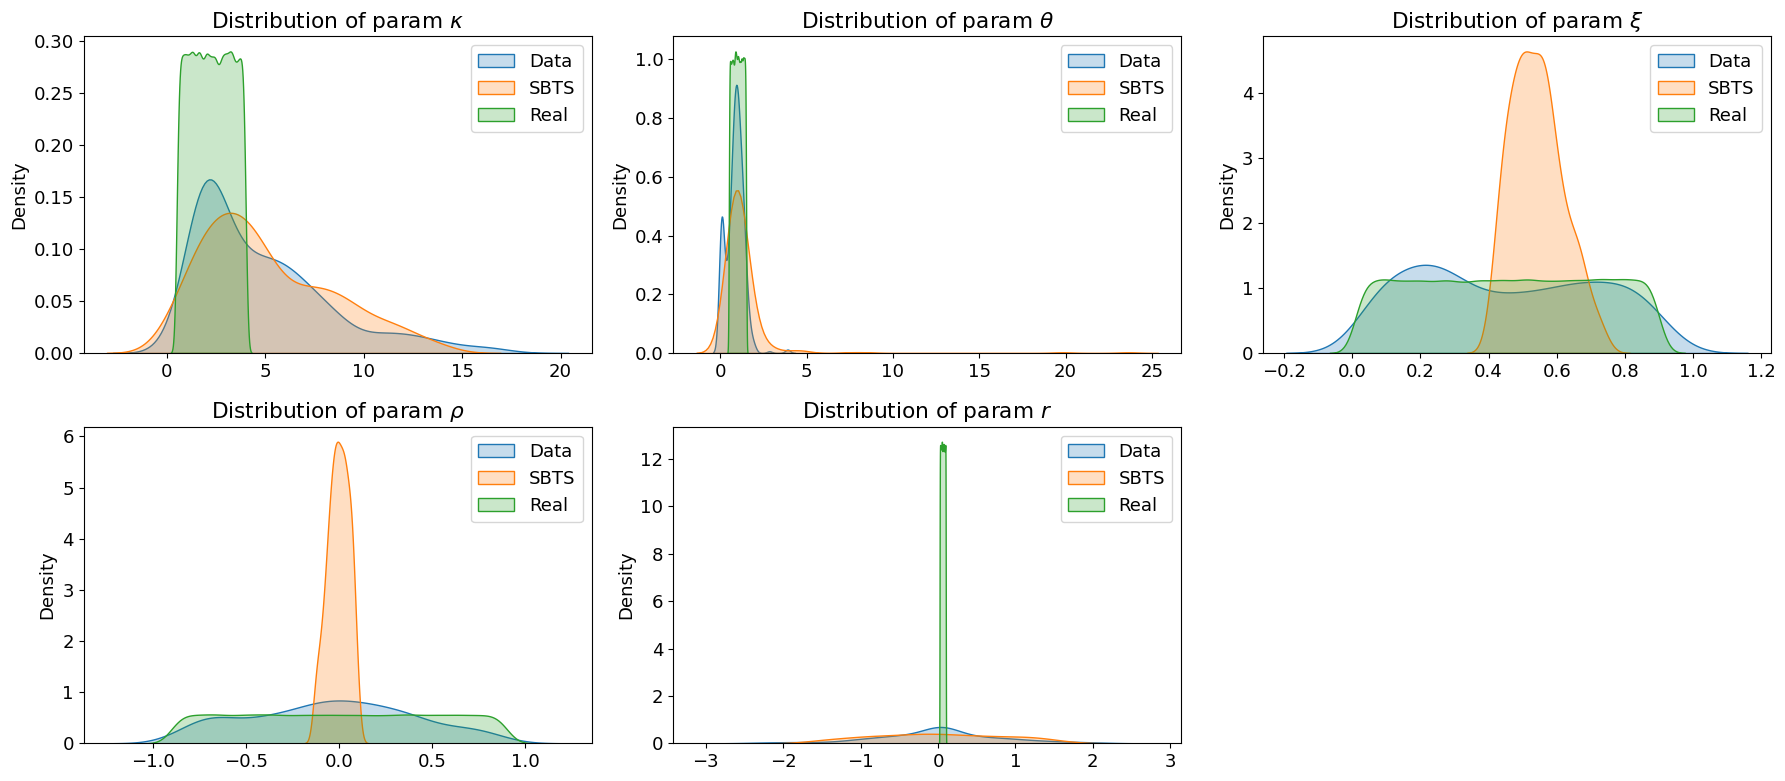

In [69]:
plot_params_distrib_Heston(X_heston, X_heston_sbts, dt=deltati)

## Discriminative and Predictive Score Computation: Illustration on Multivariate AR Data

In [4]:
M = 1000
Generate_AR_multi = Generate_Data(M)

N = 24
d=5
phi=0.5
sigma=0.8
x0=0
deltati = 1

X_ar = Generate_AR_multi.generate_AR_multi(N, d, phi, sigma, x0)

X_ar_sbts = simulateSB_multi_mark(N, M, d, K=1, X=X_ar, N_pi=100, h=0.5, deltati=deltati, M_simu=1000)
X_ar = X_ar[:, 1:]

Start time: 10:18:34
Expected finish time: 10:20:51
Finish time: 10:21:14
Time with numba to generate 1000 samples with N_pi=100: 159 seconds.


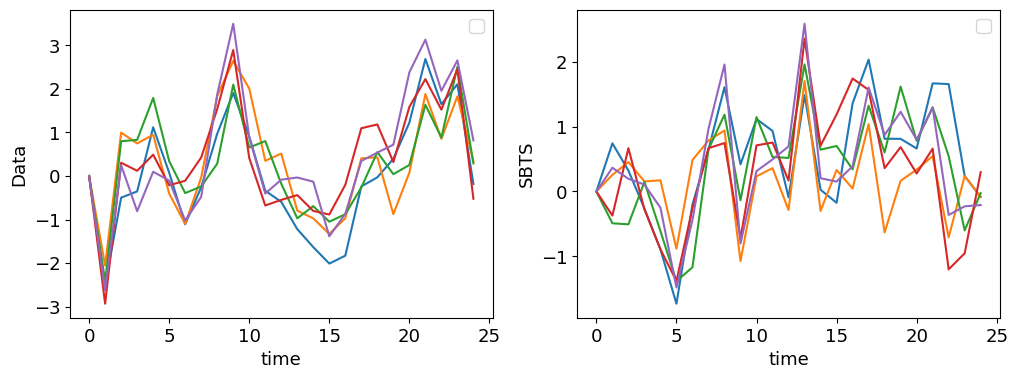

In [34]:
plot_sample_multi(X_ar, X_ar_sbts, x0=0)

In [5]:
disc, pred = get_scores(X_ar, X_ar_sbts, itt=2000, n_temp=10, min_max=True, device=device)

Start time: 10:21:14
Expected finish time: 11:02:21
Discriminative score (lower the better): 0.035 +- 0.022
Predictive score (lower the better): 0.09 +- 0.002


## Benchmark on Additional Metrics: Stock Dataset

In [3]:
xpath = os.path.join('metrics/fbm_stock_metrics/data/', 'X_stock.pt')
X_stock = torch.load(xpath, map_location=device).to(torch.float32)[:, :].to(device)
M, N, d = X_stock.shape
log_returns = np.zeros((M, N+1, d))
log_returns[:, 1:] = X_stock.numpy()
log_returns.shape

(1002, 11, 5)

In [51]:
deltati = 1/252
h=0.2

X_stock_sbts = simulateSB_multi(N, M, d, X=log_returns, N_pi=100, h=h, deltati=deltati, M_simu=1000)

Start time: 10:03:55
Expected finish time: 10:05:25
Finish time: 10:05:28
Time with numba to generate 1000 samples with N_pi=100: 93 seconds.


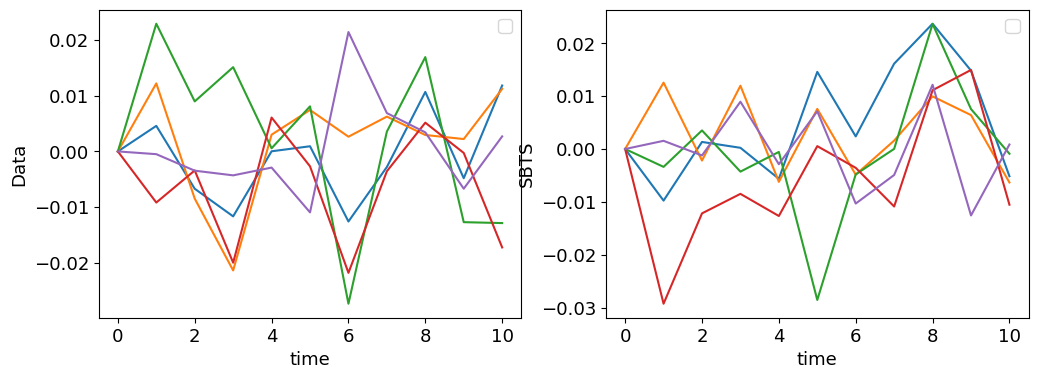

In [57]:
plot_sample_multi(X_stock, X_stock_sbts, x0=0)

In [66]:
get_stats(X_stock.numpy(), X_stock_sbts)

,1% Data,1% SBTS,99% Data,99% SBTS,Mean Data,Mean SBTS,Std Data,Std SBTS,Min Data,Min SBTS,Max Data,Max SBTS
Feature,,,,,,,,,,,,
0,-0.038,-0.038,0.037,0.039,0.001,0.001,0.014,0.015,-0.107,-0.116,0.086,0.090
1,-0.028,-0.028,0.025,0.026,0.001,0.001,0.010,0.011,-0.071,-0.073,0.057,0.065
2,-0.036,-0.038,0.037,0.036,0.001,0.001,0.014,0.014,-0.133,-0.132,0.085,0.089
3,-0.047,-0.043,0.041,0.039,0.001,0.001,0.017,0.016,-0.140,-0.142,0.142,0.149
4,-0.021,-0.023,0.022,0.023,0.000,0.000,0.010,0.010,-0.195,-0.205,0.172,0.181


In [141]:
X_stock_sbts_ = torch.tensor(X_stock_sbts, dtype=torch.float32).to(device)
X_stock.shape, X_stock_sbts_.shape

(torch.Size([1002, 10, 5]), torch.Size([1000, 10, 5]))

In [138]:
path_file = os.path.join('metrics/fbm_stock_metrics/configs/', 'evaluation_config_Stock.yaml')
with open(path_file, 'r') as file:
    config_ = yaml.safe_load(file)

config = ConfigDict(config_)
config.device = device
config.seed = 987
res_df = full_evaluation_latest(config, X_stock, X_stock_sbts_)

---- evaluation metric = acf_loss in group = stylized_fact_scores ----


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.15it/s]


---- evaluation metric = cross_corr in group = stylized_fact_scores ----


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.60it/s]


---- evaluation metric = discriminative_score in group = implicit_scores ----


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:31<00:00, 30.36s/it]


---- evaluation metric = predictive_score in group = implicit_scores ----


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:08<00:00, 13.75s/it]


---- evaluation metric = onnd in group = distance_based_metrics ----


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.56it/s]

 No metrics enabled in group = tail_scores


In [140]:
res_df.T

,0
acf_loss_mean,0.192604
acf_loss_std,0.008729
cross_corr_mean,0.032324
cross_corr_std,0.001488
discriminative_score_mean,0.012000
discriminative_score_std,0.011336
predictive_score_mean,0.008636
predictive_score_std,0.000160
onnd_mean,0.025008
onnd_std,0.000194
